## Analyzing Sentiment Data with Finbert

**Load Model**

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import feedparser
import requests


MODEL_NAME = "ProsusAI/finbert" #tabularisai/ModernFinBERT" or "ProsusAI/finbert"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.eval()

id2label = model.config.id2label  # e.g. {0: 'negative', 1: 'neutral', 2: 'positive'}

print(f"{MODEL_NAME} loaded")

c:\Users\skurono\Desktop\SCMC\scmc-2025\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ProsusAI/finbert loaded


**Sanity Inference Check**

In [2]:
pipe = pipeline("text-classification", model=MODEL_NAME)

#inference check (positive)
print(pipe('Stocks rallied and the British pound gained'))

Device set to use cpu


[{'label': 'positive', 'score': 0.6949422359466553}]


**Load Data and Check master DF**

In [20]:
from collections import Counter
import re
import pandas as pd
master = pd.read_csv('./processed_data/master/master_corpus_final.csv')
#Check rows and validate final dataset
print(master.head())
print(master["ticker"].unique())

df = master.copy()
TEXT_COL = "text"   # change if needed

assert TEXT_COL in df.columns, f"Missing column: {TEXT_COL}"

# --- basic integrity ---
print("Rows:", len(df))
print("Columns:", list(df.columns))

# enforce string + fill NaNs
df[TEXT_COL] = df[TEXT_COL].astype(str).fillna("")

# --- empty / whitespace detection ---
df["is_empty"] = df[TEXT_COL].str.strip().eq("")
print("\nEmpty rows:", df["is_empty"].sum())

# --- extremely short fragments ---
df["char_len"] = df[TEXT_COL].str.len()
print("Rows < 20 chars:", (df["char_len"] < 20).sum())

# --- extremely long rows (will truncate at 512 tokens) ---
print("Rows > 2000 chars:", (df["char_len"] > 2000).sum())
print("Max length:", df["char_len"].max())

# peek at extremes
display(df.sort_values("char_len").head(5)[[TEXT_COL,"char_len"]])
display(df.sort_values("char_len").tail(5)[[TEXT_COL,"char_len"]])

# --- duplicate detection ---
dup_rows = df.duplicated(subset=[TEXT_COL]).sum()
print("\nDuplicate text rows:", dup_rows)

# --- repeated boilerplate detector (top 10 repeated snippets) ---
most_common = Counter(df[TEXT_COL]).most_common(10)
print("\nMost repeated texts:")
for t, c in most_common:
    if c > 5:
        print(f"  {c}x ->", t[:120].replace("\n"," ") + "...")

# --- garbage / artifact heuristic flags ---
def looks_like_html(s):
    return bool(re.search(r"<[^>]+>", s))

def looks_like_json(s):
    return s.strip().startswith("{") and s.strip().endswith("}")

df["html_like"] = df[TEXT_COL].apply(looks_like_html)
df["json_like"] = df[TEXT_COL].apply(looks_like_json)

print("\nPossible HTML rows:", df["html_like"].sum())
print("Possible JSON blobs:", df["json_like"].sum())

# --- language / encoding artifacts (optional heuristic) ---
df["high_symbol_ratio"] = (df[TEXT_COL].str.count(r"[^A-Za-z0-9\s.,;:$%-]") / df["char_len"].clip(lower=1)) > 0.25
print("Rows with many strange symbols:", df["high_symbol_ratio"].sum())



                          id                report_id ticker company  \
0  Aritzia-Inc-Q1-2025-MDA-0  Aritzia-Inc-Q1-2025-MDA    ATZ     NaN   
1  Aritzia-Inc-Q1-2025-MDA-1  Aritzia-Inc-Q1-2025-MDA    ATZ     NaN   
2  Aritzia-Inc-Q1-2025-MDA-2  Aritzia-Inc-Q1-2025-MDA    ATZ     NaN   
3  Aritzia-Inc-Q1-2025-MDA-3  Aritzia-Inc-Q1-2025-MDA    ATZ     NaN   
4  Aritzia-Inc-Q1-2025-MDA-4  Aritzia-Inc-Q1-2025-MDA    ATZ     NaN   

         date      source doc_type item section_type section_heading  \
0  2024-05-02  mda_canada     md&a  NaN         md&a             NaN   
1  2024-05-02  mda_canada     md&a  NaN         md&a             NaN   
2  2024-05-02  mda_canada     md&a  NaN         md&a             NaN   
3  2024-05-02  mda_canada     md&a  NaN         md&a             NaN   
4  2024-05-02  mda_canada     md&a  NaN         md&a             NaN   

   chunk_index  page_start  page_end  \
0            0         1.0       3.0   
1            1         3.0       3.0   
2            2

,text,char_len
1422,% ),3
2761,1q26,4
3164,peers,5
1425,mix ),5
2282,peers,5


,text,char_len
5757,The Dow and S&P 500 notched new records on Thu...,17559
5755,The Dow and S&P 500 notched new records on Thu...,17559
5754,The Dow and S&P 500 notched new records on Thu...,17559
5770,The Dow and S&P 500 notched new records on Thu...,17559
5753,The Dow and S&P 500 notched new records on Thu...,17559



Duplicate text rows: 1284

Most repeated texts:
  14x -> events ), with 4q net revenue ( ex - 53rd week ) expected to increase 28 - 31 %, according to guidance gross margin expa...
  13x -> expected to gain 20 - 23. 5 %, based on guidance gross margin expanded 359 bps to 43. 8 %, 250 bps ahead of consensus, d...
  13x -> post - 1q earnings outlook : aritzia could surpass 2q guidance for 19 - 22 % sales growth ( vs. analysts'20. 8 % ) and i...
  13x -> expected to increase 19 - 22 %, according to guidance gross margin expanded 320 bps to 47. 2 %, 20 bps ahead of consensu...
  13x -> to increase 3 - 7 %, based on guidance gross margin expanded 522 bps to 40. 2 %, 71 bps ahead of consensus'39. 5 %, on l...
  13x -> rise 7 - 10 %, based on guidance gross margin climbed 510 bps to 44 %, 64 bps ahead of consensus'43. 4 %, on lower markd...
  12x -> post - 3q earnings outlook : aritzia could meet the high end of 4q sales guidance of 31 % growth ( adjusting for the ext...
  12x -> rise 3 - 7 

**Run Model**

In [22]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Paths
MASTER_PATH = "./processed_data/master/master_corpus_final.csv"
OUTPUT_PATH = "./processed_data/master/master_corpus_final_finbert.csv"

# Load data
df = master
print(df.shape)

# FinBERT model
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def score_batch(texts):
    enc = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        out = model(**enc).logits
        probs = out.softmax(dim=-1).cpu().numpy()
    return probs  # columns: [neg, neu, pos]

# Run in batches
batch_size = 16
neg_list, neu_list, pos_list = [], [], []
for i in range(0, len(df), batch_size):
    batch = df["text"].iloc[i:i+batch_size].fillna("").tolist()
    probs = score_batch(batch)
    neg_list.extend(probs[:, 0])
    neu_list.extend(probs[:, 1])
    pos_list.extend(probs[:, 2])
    if i % 100 == 0:
        print(f"scored {i} / {len(df)}")

df["finbert_neg"] = neg_list
df["finbert_neu"] = neu_list
df["finbert_pos"] = pos_list
df["finbert_score"] = df["finbert_pos"] - df["finbert_neg"]  # simple sentiment score

df.to_csv(OUTPUT_PATH, index=False)
print(f"Saved {len(df)} rows -> {OUTPUT_PATH}")
df.head()


(5913, 15)
scored 0 / 5913
scored 400 / 5913
scored 800 / 5913
scored 1200 / 5913
scored 1600 / 5913
scored 2000 / 5913
scored 2400 / 5913
scored 2800 / 5913
scored 3200 / 5913
scored 3600 / 5913
scored 4000 / 5913
scored 4400 / 5913
scored 4800 / 5913
scored 5200 / 5913
scored 5600 / 5913
Saved 5913 rows -> ./processed_data/master/master_corpus_final_finbert.csv


,id,report_id,ticker,company,date,source,doc_type,item,section_type,section_heading,chunk_index,page_start,page_end,text,source_file,finbert_neg,finbert_neu,finbert_pos,finbert_score
0,Aritzia-Inc-Q1-2025-MDA-0,Aritzia-Inc-Q1-2025-MDA,ATZ,NaN,2024-05-02,mda_canada,md&a,NaN,md&a,NaN,0,1.0,3.0,"First Quarter Ended June 2, 2024 July 11, 2024...",nlp\raw_data\sec_can\atz_q_mda\Aritzia-Inc-Q1-...,0.031711,0.047869,0.920421,0.888710
1,Aritzia-Inc-Q1-2025-MDA-1,Aritzia-Inc-Q1-2025-MDA,ATZ,NaN,2024-05-02,mda_canada,md&a,NaN,md&a,NaN,1,3.0,3.0,BASIS OF PRESENTATION Our audited annual conso...,nlp\raw_data\sec_can\atz_q_mda\Aritzia-Inc-Q1-...,0.040549,0.016261,0.943190,0.902642
2,Aritzia-Inc-Q1-2025-MDA-2,Aritzia-Inc-Q1-2025-MDA,ATZ,NaN,2024-05-02,mda_canada,md&a,NaN,md&a,NaN,2,3.0,4.0,"Our Approach Aritzia means style, not trend, a...",nlp\raw_data\sec_can\atz_q_mda\Aritzia-Inc-Q1-...,0.050114,0.014334,0.935552,0.885438
3,Aritzia-Inc-Q1-2025-MDA-3,Aritzia-Inc-Q1-2025-MDA,ATZ,NaN,2024-05-02,mda_canada,md&a,NaN,md&a,NaN,3,4.0,4.0,"Q1 2025 For Q1 2025, compared to Q1 2024: – Ne...",nlp\raw_data\sec_can\atz_q_mda\Aritzia-Inc-Q1-...,0.926430,0.023223,0.050346,-0.876084
4,Aritzia-Inc-Q1-2025-MDA-4,Aritzia-Inc-Q1-2025-MDA,ATZ,NaN,2024-05-02,mda_canada,md&a,NaN,md&a,NaN,4,4.0,5.0,See the sections below entitled “How We Assess...,nlp\raw_data\sec_can\atz_q_mda\Aritzia-Inc-Q1-...,0.019545,0.078133,0.902322,0.882777


**Evaluate and Calculate Final Scores**

In [42]:
print(df["ticker"].unique())
print(df["source"].unique())
print(df.columns)
score_df = df[[
    "id",
    "ticker",
    "date",
    "source",
    #"doc_type",
    "section_heading",
    "text",
    "finbert_neg",
    "finbert_neu",
    "finbert_pos"
]]

score_df = score_df.copy()


print(score_df.head())

score_df[["finbert_pos","finbert_neg","finbert_neu"]] = (
    score_df[["finbert_pos","finbert_neg","finbert_neu"]].astype(float)
)
score_df.loc[:, "cwds_score"] = (score_df["finbert_pos"]-score_df["finbert_neg"]) * (1 - score_df["finbert_neu"])
score_df["cwds_score"] = score_df["cwds_score"].fillna(0)


print(score_df["cwds_score"])


['ATZ' 'LULU' 'NKE']
['mda_canada' 'bloomberg' 'sec' 'press_release' 'newsapi' 'yfinance']
Index(['id', 'ticker', 'date', 'source', 'section_heading', 'text',
       'finbert_neg', 'finbert_neu', 'finbert_pos', 'cwds_score'],
      dtype='object')
                          id ticker                      date      source  \
0  Aritzia-Inc-Q1-2025-MDA-0    ATZ 2024-05-02 00:00:00+00:00  mda_canada   
1  Aritzia-Inc-Q1-2025-MDA-1    ATZ 2024-05-02 00:00:00+00:00  mda_canada   
2  Aritzia-Inc-Q1-2025-MDA-2    ATZ 2024-05-02 00:00:00+00:00  mda_canada   
3  Aritzia-Inc-Q1-2025-MDA-3    ATZ 2024-05-02 00:00:00+00:00  mda_canada   
4  Aritzia-Inc-Q1-2025-MDA-4    ATZ 2024-05-02 00:00:00+00:00  mda_canada   

  section_heading                                               text  \
0             NaN  First Quarter Ended June 2, 2024 July 11, 2024...   
1             NaN  BASIS OF PRESENTATION Our audited annual conso...   
2             NaN  Our Approach Aritzia means style, not trend, a...   
3

**Calculate Metrics for table**

In [ ]:
import numpy as np
import pandas as pd

# ---------------------------------------------------------------------
# Config: adjust thresholds if needed
# ---------------------------------------------------------------------
TICKERS = ["ATZ", "LULU", "NKE"]

POS_TAIL_THRESH = 0.30   # high-confidence positive sentiment
NEG_TAIL_THRESH = -0.30  # high-confidence negative sentiment
NEU_THRESH       = 0.60  # strongly neutral if finbert_neu >= this

copy = score_df.copy()
# ---------------------------------------------------------------------
# 1. Filter to relevant tickers and ensure needed columns exist
# ---------------------------------------------------------------------
required_cols = {
    "ticker", "cwds_score",
    "finbert_neg", "finbert_neu", "finbert_pos"
}
missing = required_cols - set(score_df.columns)
if missing:
    raise ValueError(f"Missing required columns in score_df: {missing}")

sub = score_df[score_df["ticker"].isin(TICKERS)].copy()

# Ensure numeric types
sub[["cwds_score", "finbert_neg", "finbert_neu", "finbert_pos"]] = (
    sub[["cwds_score", "finbert_neg", "finbert_neu", "finbert_pos"]].astype(float)
)

g = sub.groupby("ticker")

# ---------------------------------------------------------------------
# 2. Core statistics per ticker
# ---------------------------------------------------------------------
mean_sent    = g["cwds_score"].mean()              # Market tone (level)
median_sent  = g["cwds_score"].median()            # Robust central tendency
std_sent     = g["cwds_score"].std(ddof=0)         # Dispersion (σ)

# Tail quantile (5% worst-sentiment; downside severity)
tail5_sent   = g["cwds_score"].quantile(0.05)

# ---------------------------------------------------------------------
# 3. Tail percentages and neutral share
# ---------------------------------------------------------------------
neg_tail_pct = g.apply(
    lambda df: (df["cwds_score"] <= NEG_TAIL_THRESH).mean()
) * 100.0

pos_tail_pct = g.apply(
    lambda df: (df["cwds_score"] >= POS_TAIL_THRESH).mean()
) * 100.0

# Neutral share: fraction of highly neutral passages (low info density)
neutral_share_pct = g.apply(
    lambda df: (df["finbert_neu"] >= NEU_THRESH).mean()
) * 100.0

# ---------------------------------------------------------------------
# 4. New “risk-adjusted” sentiment metrics
# ---------------------------------------------------------------------

# (a) Sentiment Conviction: mean sentiment per unit of dispersion
#     Analogue to Expected Return / Volatility
conviction = mean_sent / std_sent.replace(0, np.nan)

# (b) Downside-Adjusted Sentiment:
#     penalize level by frequency and depth of negative tails
neg_tail_share = neg_tail_pct / 100.0
downside_adj_sent = mean_sent - neg_tail_share * tail5_sent.abs()

# (c) Tail Skew: how asymmetric the extremes are (bullish vs bearish)
tail_skew = pos_tail_pct - neg_tail_pct  # positive => upside-skewed tails

# ---------------------------------------------------------------------
# 5. Assemble a detailed metrics table (for debugging / analysis)
# ---------------------------------------------------------------------
metrics_by_ticker = pd.DataFrame({
    "Mean Sentiment": mean_sent,
    "Median Sentiment": median_sent,
    "Dispersion (σ)": std_sent,
    "Tail-5% Sentiment": tail5_sent,
    "Neg-Tail %": neg_tail_pct,
    "Pos-Tail %": pos_tail_pct,
    "Neutral Share %": neutral_share_pct,
    "Sentiment Conviction": conviction,
    "Downside-Adj Sentiment": downside_adj_sent,
    "Tail Skew (Pos-Neg)": tail_skew,
})

# reorder tickers if some are missing
metrics_by_ticker = metrics_by_ticker.reindex(
    [t for t in TICKERS if t in metrics_by_ticker.index]
)

df.to_csv('./processed_data/master/master_corpus_final_finbert_metrics.csv', index=False)

print("=== Detailed metrics by ticker ===")
display(metrics_by_ticker)

# ---------------------------------------------------------------------
# 6. SCMC slide-ready table
# ---------------------------------------------------------------------
# Keep the slide table focused on a small number of interpretable metrics
slide_base = pd.DataFrame({
    "Mean Sentiment": mean_sent,
    "Sentiment Conviction": conviction,
    "Downside-Adj Sentiment": downside_adj_sent,
    "Tail Skew (Pos-Neg)": tail_skew,
    "Neutral Share %": neutral_share_pct,
}).T  # metrics as rows

slide_base.index.name = "Metric"

# enforce ticker column order
slide_base = slide_base[[t for t in TICKERS if t in slide_base.columns]]

interpretation = {
    "Mean Sentiment":          "Level of forward-looking tone",
    "Sentiment Conviction":    "Sentiment per unit of volatility (Sharpe-like)",
    "Downside-Adj Sentiment":  "Tone adjusted for downside narrative risk",
    "Tail Skew (Pos-Neg)":     "Asymmetry of extreme views (bullish vs bearish)",
    "Neutral Share %":         "Share of low-information / boilerplate text",
}

slide_base["Interpretation"] = slide_base.index.map(interpretation)

slide_table = slide_base.reset_index()

print("\n=== SCMC slide-ready table ===")
display(slide_table)


=== Detailed metrics by ticker ===


/var/folders/rh/j2fqyqcx1sq38mr45zh8hhtm0000gn/T/ipykernel_86503/1524114159.py:47: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  neg_tail_pct = g.apply(
/var/folders/rh/j2fqyqcx1sq38mr45zh8hhtm0000gn/T/ipykernel_86503/1524114159.py:51: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pos_tail_pct = g.apply(
/var/folders/rh/j2fqyqcx1sq38mr45zh8hhtm0000gn/T/ipykernel_86503/1524114159.py:56: FutureWarning: DataFrameGroupBy

,Mean Sentiment,Median Sentiment,Dispersion (σ),Tail-5% Sentiment,Neg-Tail %,Pos-Tail %,Neutral Share %,Sentiment Conviction,Downside-Adj Sentiment,Tail Skew (Pos-Neg)
ticker,,,,,,,,,,
ATZ,0.049046,0.119540,0.740372,-0.913400,37.225275,47.596154,6.936813,0.066245,-0.290970,10.370879
LULU,0.331413,0.474589,0.551462,-0.850055,12.012550,52.532497,28.910802,0.600971,0.229300,40.519946
NKE,0.346135,0.550349,0.543666,-0.763444,12.699906,56.208843,21.777987,0.636669,0.249179,43.508937



=== SCMC slide-ready table ===


ticker,Metric,ATZ,LULU,NKE,Interpretation
0,Mean Sentiment,0.049046,0.331413,0.346135,Level of forward-looking tone
1,Sentiment Conviction,0.066245,0.600971,0.636669,Sentiment per unit of volatility (Sharpe-like)
2,Downside-Adj Sentiment,-0.290970,0.229300,0.249179,Tone adjusted for downside narrative risk
3,Tail Skew (Pos-Neg),10.370879,40.519946,43.508937,Asymmetry of extreme views (bullish vs bearish)
4,Neutral Share %,6.936813,28.910802,21.777987,Share of low-information / boilerplate text


**Visualize Data**

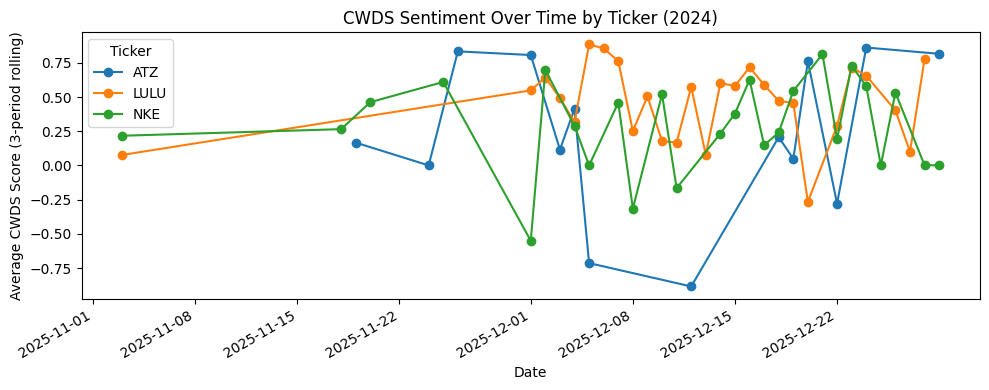

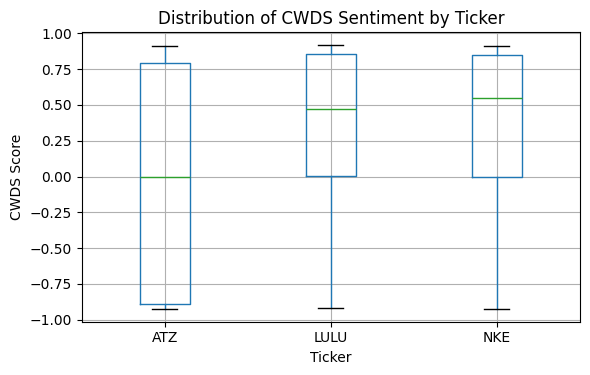

/var/folders/rh/j2fqyqcx1sq38mr45zh8hhtm0000gn/T/ipykernel_86503/472432733.py:79: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  neg_tail_pct = g.apply(lambda d: (d["cwds_score"] <= NEG_TAIL_THRESH).mean()) * 100.0
/var/folders/rh/j2fqyqcx1sq38mr45zh8hhtm0000gn/T/ipykernel_86503/472432733.py:80: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pos_tail_pct = g.apply(lambda d: (d["cwds_score"] >= POS_TAIL_THRESH).mean()) 

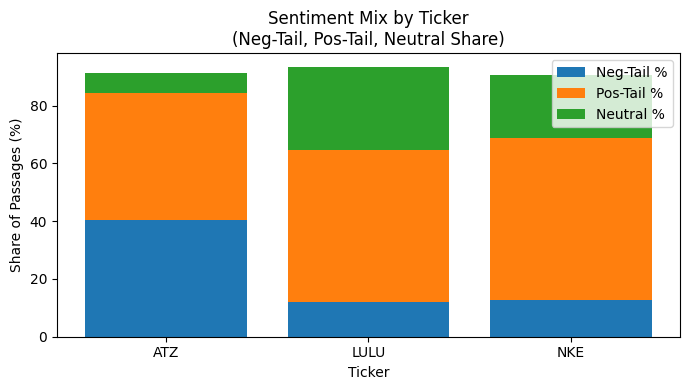

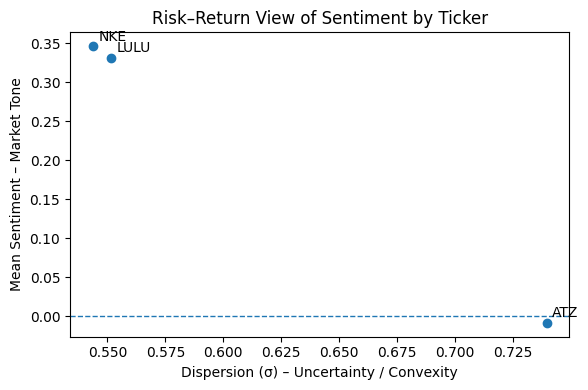

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# Ensure types and basic filtering
# ---------------------------------------------------------------------
df_plot = score_df.copy()

# Make sure date is datetime and drop rows without valid date
df_plot["date"] = pd.to_datetime(df_plot["date"], errors="coerce")
df_plot = df_plot.dropna(subset=["date", "ticker", "cwds_score"])

# If you only care about these three tickers, keep this; otherwise remove the line
focus_tickers = ["ATZ", "LULU", "NKE"]
df_plot = df_plot[df_plot["ticker"].isin(focus_tickers)]

# Ensure numeric
df_plot["cwds_score"] = df_plot["cwds_score"].astype(float)
df_plot["finbert_neu"] = df_plot["finbert_neu"].astype(float)

# Tail / neutrality thresholds (match your metrics cell)
POS_TAIL_THRESH = 0.30
NEG_TAIL_THRESH = -0.30
NEU_THRESH       = 0.60


# ---------------------------------------------------------------------
# 1) Time series: average sentiment by ticker over time (rolling smooth)
# ---------------------------------------------------------------------
# ensure date is datetime and filter to 2024
df_plot["date"] = pd.to_datetime(df_plot["date"])
df_2024 = df_plot[(df_plot["date"] >= "2025-11-01")]

ts = (
    df_2024
    .groupby(["date", "ticker"])["cwds_score"]
    .mean()
    .reset_index()
    .sort_values(["ticker", "date"])
)

fig, ax = plt.subplots(figsize=(10, 4))

for ticker, grp in ts.groupby("ticker"):
    y = grp["cwds_score"]
    ax.plot(grp["date"], y, marker="o", label=ticker)

#ax.axhline(0, linestyle="--", linewidth=1)
ax.set_title("CWDS Sentiment Over Time by Ticker (2024)")
ax.set_xlabel("Date")
ax.set_ylabel("Average CWDS Score (3-period rolling)")
ax.legend(title="Ticker")
fig.autofmt_xdate()

plt.tight_layout()
plt.show()


# ---------------------------------------------------------------------
# 2) Distribution view: boxplot of sentiment by ticker
#    (shows median, dispersion, tail behaviour)
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

df_plot.boxplot(column="cwds_score", by="ticker", ax=ax)
ax.set_title("Distribution of CWDS Sentiment by Ticker")
ax.set_xlabel("Ticker")
ax.set_ylabel("CWDS Score")
plt.suptitle("")  # remove automatic pandas title

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 3) Tail structure: Pos-tail %, Neg-tail %, Neutral share per ticker
#    (good for a “sentiment profile” slide)
# ---------------------------------------------------------------------
g = df_plot.groupby("ticker")

neg_tail_pct = g.apply(lambda d: (d["cwds_score"] <= NEG_TAIL_THRESH).mean()) * 100.0
pos_tail_pct = g.apply(lambda d: (d["cwds_score"] >= POS_TAIL_THRESH).mean()) * 100.0
neutral_pct  = g.apply(lambda d: (d["finbert_neu"] >= NEU_THRESH).mean()) * 100.0

tail_df = pd.DataFrame({
    "Neg-Tail %": neg_tail_pct,
    "Pos-Tail %": pos_tail_pct,
    "Neutral %":  neutral_pct,
})

# Stacked bar chart – sentiment mix per ticker
fig, ax = plt.subplots(figsize=(7, 4))

bottom = None
for col in ["Neg-Tail %", "Pos-Tail %", "Neutral %"]:
    if bottom is None:
        ax.bar(tail_df.index, tail_df[col].values, label=col)
        bottom = tail_df[col].values
    else:
        ax.bar(tail_df.index, tail_df[col].values, bottom=bottom, label=col)
        bottom = bottom + tail_df[col].values

ax.set_title("Sentiment Mix by Ticker\n(Neg-Tail, Pos-Tail, Neutral Share)")
ax.set_xlabel("Ticker")
ax.set_ylabel("Share of Passages (%)")
ax.legend()

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 4) Risk/return style view: mean vs dispersion (σ) scatter
#    (plots “market tone” vs “uncertainty / convexity”)
# ---------------------------------------------------------------------
mean_sent = g["cwds_score"].mean()
std_sent  = g["cwds_score"].std(ddof=0)

scatter_df = pd.DataFrame({"Mean Sentiment": mean_sent, "Dispersion (σ)": std_sent})

fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(scatter_df["Dispersion (σ)"], scatter_df["Mean Sentiment"])

for ticker, row in scatter_df.iterrows():
    ax.annotate(ticker, (row["Dispersion (σ)"], row["Mean Sentiment"]), xytext=(4, 4),
                textcoords="offset points")

ax.axhline(0, linestyle="--", linewidth=1)
ax.set_title("Risk–Return View of Sentiment by Ticker")
ax.set_xlabel("Dispersion (σ) – Uncertainty / Convexity")
ax.set_ylabel("Mean Sentiment – Market Tone")

plt.tight_layout()
plt.show()


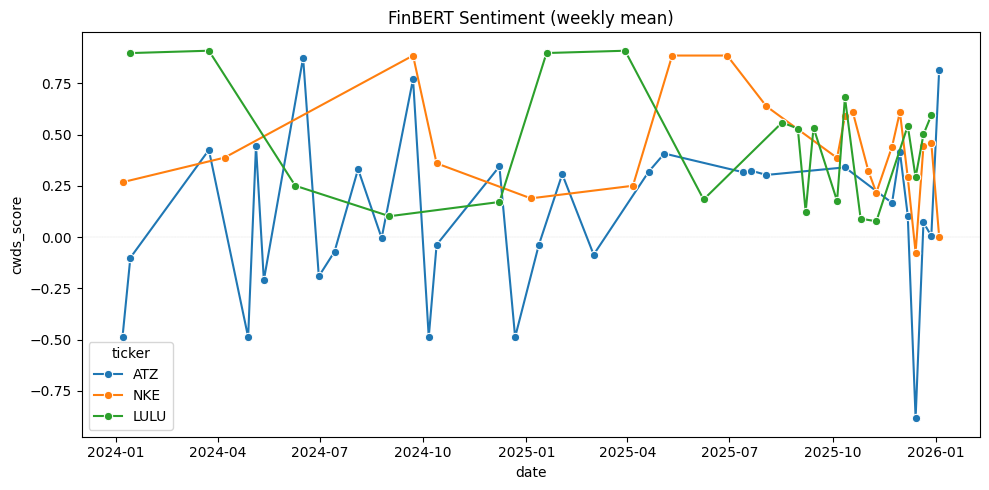

/var/folders/rh/j2fqyqcx1sq38mr45zh8hhtm0000gn/T/ipykernel_86503/1083250821.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=src.sort_values('cwds_score_mean'), x='cwds_score_mean', y='source', palette='coolwarm')


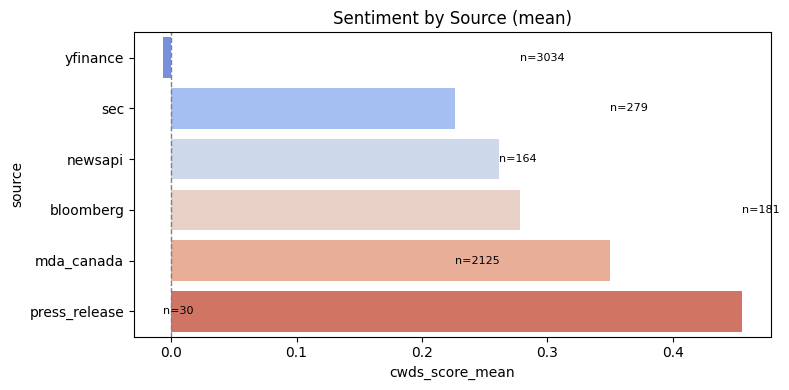

,ticker,mean,median,count
0,ATZ,0.049046,0.119540,1456
1,LULU,0.331413,0.474589,2231
2,NKE,0.346135,0.550349,2126


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assumes score_df already exists; if not, uncomment to load
# score_df = pd.read_csv('nlp/processed_data/final/master_corpus_finbert.csv')

if 'date' in score_df.columns:
    score_df['date'] = pd.to_datetime(score_df['date'], errors='coerce', utc=True)

# 1) Sentiment over time by ticker (weekly mean)

if 'date' in score_df.columns:
    weekly = (score_df
              .dropna(subset=['date'])
              .groupby([pd.Grouper(key='date', freq='W'), 'ticker'])['cwds_score']
              .mean()
              .reset_index())
    weekly["date"] = pd.to_datetime(weekly["date"])
    weekly = weekly[weekly["date"] >= "202-01-01"]
    plt.figure(figsize=(10,5))
    sns.lineplot(data=weekly, x='date', y='cwds_score', hue='ticker', marker='o')
    plt.title('FinBERT Sentiment (weekly mean)')
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.1)
    plt.tight_layout()
    plt.show()

# 2) Sentiment by source/doc_type (bar with counts)
if {'source','cwds_score'} <= set(score_df.columns):
    src = score_df.groupby('source').agg(cwds_score_mean=('cwds_score','mean'), n=('id','count')).reset_index()
    plt.figure(figsize=(8,4))
    sns.barplot(data=src.sort_values('cwds_score_mean'), x='cwds_score_mean', y='source', palette='coolwarm')
    plt.title('Sentiment by Source (mean)')
    for i,row in src.iterrows():
        plt.text(row['cwds_score_mean'], i, f"n={row['n']}", va='center', ha='left', fontsize=8)
    plt.axvline(0, color='gray', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.show()

# 3) Section-type sentiment per ticker (boxplot)
if {'section_type','cwds_score','ticker'} <= set(score_df.columns):
    plt.figure(figsize=(10,5))
    sns.boxplot(data=score_df, x='section_type', y='cwds_score', hue='ticker')
    plt.title('Sentiment by Section Type and Ticker')
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

summary = score_df.groupby('ticker')['cwds_score'].agg(['mean','median','count']).reset_index()
summary


In [36]:
# Ensure you have these columns in your dataframe:
# - "source" (e.g., yfinance/newsapi/sec/etc.)
# - "cwds_score" (your numeric sentiment score; swap in whatever column you use)
# - "label" (FinBERT class: negative/neutral/positive)

df = copy.copy()

# Mean sentiment per source
sent_by_source = (
    df.groupby(["source", "ticker"])["cwds_score"]
      .agg(["count", "mean"])
      .reset_index()
      .sort_values("mean", ascending=False)
)
display(sent_by_source)

# Label distribution per source
label_dist = (
    df.groupby("source")
      .size()
      .reset_index(name="count")
      .pivot(index="source", values="count")
      .fillna(0)
      .astype(int)
)
display(label_dist)

# Optional: normalized proportions
label_dist_pct = label_dist.div(label_dist.sum(axis=1), axis=0).round(3)
display(label_dist_pct)


                          id ticker                      date      source  \
0  Aritzia-Inc-Q1-2025-MDA-0    ATZ 2024-05-02 00:00:00+00:00  mda_canada   
1  Aritzia-Inc-Q1-2025-MDA-1    ATZ 2024-05-02 00:00:00+00:00  mda_canada   
2  Aritzia-Inc-Q1-2025-MDA-2    ATZ 2024-05-02 00:00:00+00:00  mda_canada   
3  Aritzia-Inc-Q1-2025-MDA-3    ATZ 2024-05-02 00:00:00+00:00  mda_canada   
4  Aritzia-Inc-Q1-2025-MDA-4    ATZ 2024-05-02 00:00:00+00:00  mda_canada   

  section_heading                                               text  \
0             NaN  First Quarter Ended June 2, 2024 July 11, 2024...   
1             NaN  BASIS OF PRESENTATION Our audited annual conso...   
2             NaN  Our Approach Aritzia means style, not trend, a...   
3             NaN  Q1 2025 For Q1 2025, compared to Q1 2024: – Ne...   
4             NaN  See the sections below entitled “How We Assess...   

   finbert_neg  finbert_neu  finbert_pos  cwds_score  
0     0.031711     0.047869     0.920421    0.846

,source,ticker,count,mean
2,bloomberg,NKE,1064,0.486388
7,press_release,ATZ,181,0.454838
1,bloomberg,LULU,992,0.441164
5,newsapi,LULU,99,0.401542
4,newsapi,ATZ,8,0.358276
3,mda_canada,ATZ,279,0.349869
8,sec,LULU,1130,0.231695
9,sec,NKE,995,0.219953
10,yfinance,ATZ,10,0.035598
11,yfinance,LULU,10,0.017892


TypeError: DataFrame.pivot() missing 1 required keyword-only argument: 'columns'

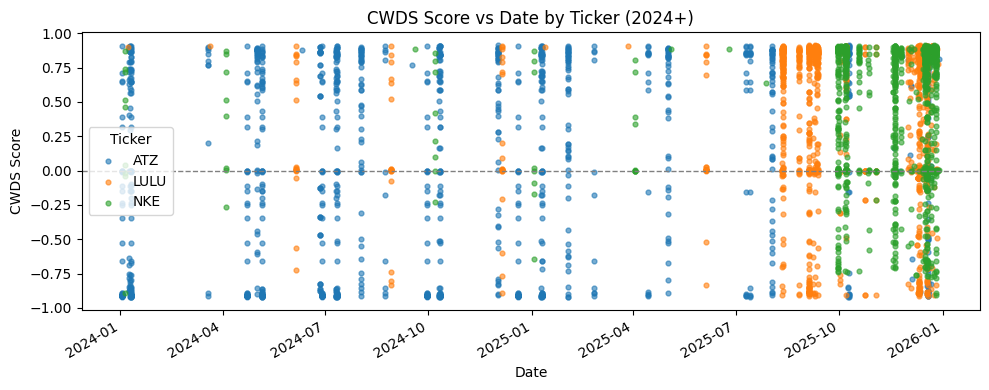

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

df_plot = copy.copy()
df_plot["date"] = pd.to_datetime(df_plot["date"])
df_2024 = df_plot[df_plot["date"] >= "2024-01-01"]

fig, ax = plt.subplots(figsize=(10, 4))
for ticker, grp in df_2024.groupby("ticker"):
    ax.scatter(grp["date"], grp["cwds_score"], s=12, alpha=0.6, label=ticker)

ax.axhline(0, linestyle="--", color="gray", linewidth=1)
ax.set_title("CWDS Score vs Date by Ticker (2024+)")
ax.set_xlabel("Date")
ax.set_ylabel("CWDS Score")
ax.legend(title="Ticker")
fig.autofmt_xdate()

plt.tight_layout()
plt.show()


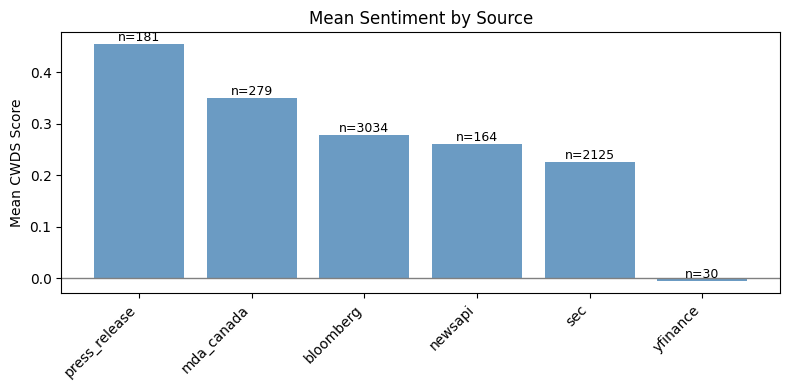

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

df_bar = copy.copy()  # replace with your dataframe
agg = (
    df_bar.groupby("source")["cwds_score"]
          .agg(mean="mean", count="count")
          .reset_index()
          .sort_values("mean", ascending=False)
)

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(agg["source"], agg["mean"], color="steelblue", alpha=0.8)

# Add count labels above bars
for bar, cnt in zip(bars, agg["count"]):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"n={cnt}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

ax.axhline(0, color="gray", linewidth=1)
ax.set_ylabel("Mean CWDS Score")
ax.set_title("Mean Sentiment by Source")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
